In [1]:
import torch
from PIL import Image
from pathlib import Path
from os import listdir, path
from torch.utils.data import Dataset
from torchvision.transforms import PILToTensor, ToTensor
from torch.nn.functional import pad

class CarvanaDataset(Dataset):
    toTensor = ToTensor()
    pilToTensor = PILToTensor()

    def __init__(self, image_directory, mask_directory, mask_suffix = "_mask", train=True):
        self.image_directory = Path(image_directory)
        self.mask_directory = Path(mask_directory)
        self.mask_suffix = mask_suffix
        
        self.image_ids = []
        for file_name in listdir(image_directory):
            if path.isfile(path.join(image_directory, file_name)) and not file_name.startswith("."):
                if train != file_name.split("_")[0].endswith(("1", "2", "3", "4")):
                    self.image_ids.append(file_name.split(".")[0])

        print(f"Images directory has {len(self.image_ids)} entries.")
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, index):
        target_id = self.image_ids[index]
        image_path = path.join(self.image_directory, target_id + ".jpg")
        mask_path = path.join(self.mask_directory, target_id + self.mask_suffix + ".gif")
        
        image = Image.open(image_path)
        mask = Image.open(mask_path)
        
        return pad(self.toTensor(image), (0, 1), "replicate"), pad(self.pilToTensor(mask), (0, 1), value=0).to(torch.float)

In [2]:
from torch.utils.data import DataLoader

batch_size = 6

train_path = "./data/train_small/"
train_masks_path = "./data/train_small_masks/"

train_dataset = CarvanaDataset(train_path, train_masks_path, train=True)
test_dataset = CarvanaDataset(train_path, train_masks_path, train=False)
train_dataloader = DataLoader(train_dataset, batch_size)
test_dataloader = DataLoader(test_dataset, batch_size)

x, y = train_dataset[0]
print(x.shape, y.shape)

Images directory has 3680 entries.
Images directory has 1408 entries.
torch.Size([3, 640, 960]) torch.Size([1, 640, 960])


In [3]:
import matplotlib.pyplot as plot

In [ ]:
plot.imshow(x.permute(1, 2, 0))

In [ ]:
plot.imshow(y.squeeze(), cmap="gray")

In [4]:
import torch.nn as nn

class UNet(nn.Module):
    @staticmethod
    def DoubleConv2d(input_channels, output_channels, input_kernel_size, inter_kernel_size):
        return nn.Sequential(
            nn.Conv2d(input_channels, output_channels, input_kernel_size, 1, (input_kernel_size-1)//2, bias=False),
            nn.InstanceNorm2d(output_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(output_channels, output_channels, inter_kernel_size, 1, (inter_kernel_size-1)//2, bias=False),
            nn.InstanceNorm2d(output_channels),
            nn.LeakyReLU(inplace=True)
        )
    
    @staticmethod
    def ConvTranspose2d(input_channels, output_channels, kernel_size):
        return nn.ConvTranspose2d(input_channels, output_channels, kernel_size, 2, (kernel_size-1)//2, output_padding=1)

    def __init__(self):
        super().__init__()
        
        input_channels = 3
        output_channels = 1

        self.conv_down_1 = self.DoubleConv2d(input_channels, 64, 5, 3)
        self.pool_1 = nn.MaxPool2d(2)
            
        self.conv_down_2 = self.DoubleConv2d(64, 96, 3, 3)
        self.pool_2 = nn.MaxPool2d(2)
            
        self.conv_down_3 = self.DoubleConv2d(96, 128, 3, 3)
        self.pool_3 = nn.MaxPool2d(2)

        self.conv_down_4 = self.DoubleConv2d(128, 160, 3, 3)
        self.pool_4 = nn.MaxPool2d(2)
            
        self.conv_down_5 = self.DoubleConv2d(160, 192, 3, 3)

        self.conv_transpose_1 = self.ConvTranspose2d(192, 160, 3)
        # cat conv_transpose_1 = 160, down_conv_4 = 160 -> Total 320
        self.conv_up_1 = self.DoubleConv2d(320, 160, 3, 3)

        self.conv_transpose_2 = self.ConvTranspose2d(160, 128, 3)
        # cat conv_transpose_2 = 128, down_conv_3 = 128 -> Total 256
        self.conv_up_2 = self.DoubleConv2d(256, 128, 3, 3)
        
        self.conv_transpose_3 = self.ConvTranspose2d(128, 96, 3)
        # cat conv_transpose_3 = 96, down_conv_2 = 96 -> Total 192
        self.conv_up_3 = self.DoubleConv2d(192, 96, 3, 3)
        
        self.conv_transpose_4 = self.ConvTranspose2d(96, 64, 3)
        # cat conv_transpose_4 = 64, down_conv_1 = 64 -> Total 128
        self.conv_up_4 = self.DoubleConv2d(128, 64, 3, 3)
        
        self.conv_out = nn.Conv2d(64, output_channels, kernel_size=1)
    
    def forward(self, x):
        x_conv_down_1 = self.conv_down_1(x)
        x_conv_down_2 = self.conv_down_2(self.pool_1(x_conv_down_1))
        x_conv_down_3 = self.conv_down_3(self.pool_2(x_conv_down_2))
        x_conv_down_4 = self.conv_down_4(self.pool_3(x_conv_down_3))
        x_conv_down_5 = self.conv_down_5(self.pool_4(x_conv_down_4))
        
        x_conv_transpose_1 = self.conv_transpose_1(x_conv_down_5)
        x_cat_1 = torch.cat([ x_conv_transpose_1, x_conv_down_4 ], dim=1)
        x_conv_up_1 = self.conv_up_1(x_cat_1)

        x_conv_transpose_2 = self.conv_transpose_2(x_conv_up_1)
        x_cat_2 = torch.cat([ x_conv_transpose_2, x_conv_down_3 ], dim=1)
        x_conv_up_2 = self.conv_up_2(x_cat_2)

        x_conv_transpose_3 = self.conv_transpose_3(x_conv_up_2)
        x_cat_3 = torch.cat([ x_conv_transpose_3, x_conv_down_2 ], dim=1)
        x_conv_up_3 = self.conv_up_3(x_cat_3)

        x_conv_transpose_4 = self.conv_transpose_4(x_conv_up_3)
        x_cat_4 = torch.cat([ x_conv_transpose_4, x_conv_down_1 ], dim=1)
        x_conv_up_4 = self.conv_up_4(x_cat_4)

        output = self.conv_out(x_conv_up_4)

        return output

In [5]:
device = ( "cuda" if torch.cuda.is_available() else "cpu" )
if device == "cpu":
    raise Exception("CUDA is not available. Please enable.")

model = UNet().to(device)
print(model)

UNet(
  (conv_down_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_down_2): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(96, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): InstanceNorm2d(96, eps=1e-05, momentum=0.1, a

In [6]:
model.load_state_dict(torch.load("./checkpoints/model_10.pth"))
x, y = test_dataset[0]
x = x[None, ...].to(device)
with torch.no_grad():
    model.eval()
    predicted = model(x)

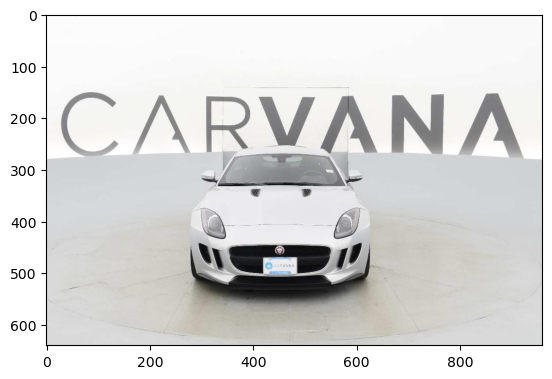

In [7]:
plot.imshow(x.cpu()[0].permute(1, 2, 0))

Accuracy: 0.997060546875


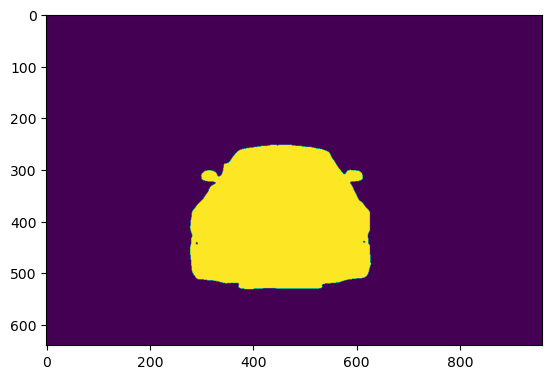

In [8]:
predicted_3d = predicted.cpu()[0]
torch.sigmoid_(predicted_3d)
predicted_3d = (predicted_3d > 0.5).to(torch.int)
plot.imshow(predicted_3d.permute(1, 2, 0))
# Good enough honestly for 10 epochs and not particularly powerful Unet

print("Accuracy:", (predicted_3d == y).to(torch.int).sum().item() / torch.numel(y))

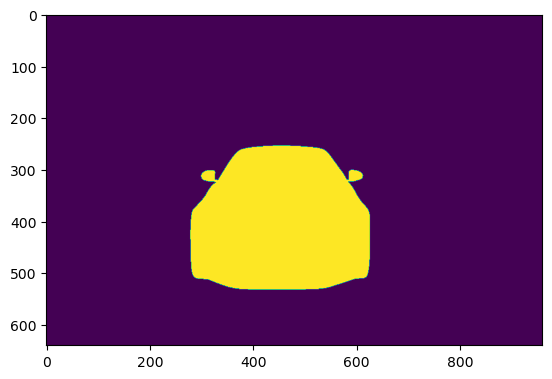

In [9]:
plot.imshow(y.permute(1, 2, 0))

In [ ]:
max_norm = 1.0

def train(dataloader, model, loss_function, optimizer, gradient_scaler):
    model.train()
    total_batches = len(dataloader)
    for i, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        
        with torch.cuda.amp.autocast():
            prediction = model(x)
            loss = loss_function(prediction, y)
        
        gradient_scaler.scale(loss).backward()
        gradient_scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        gradient_scaler.step(optimizer)
        gradient_scaler.update()
        optimizer.zero_grad()

        if i == total_batches - 1:
            print(f"Loss: {loss}")

def test(dataloader, model, loss_function, scheduler):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            with torch.cuda.amp.autocast():
                prediction = model(x)
            total_loss += loss_function(prediction, y).item()
    scheduler.step(total_loss / len(dataloader)) # Divide anyways for correct thresholding
    print(f"Average Loss: {total_loss / len(dataloader)}")

In [13]:
epochs = 500

gradient_scaler = torch.cuda.amp.GradScaler()
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.NAdam(model.parameters(), lr=0.003)
reduce_lr = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2)

for i in range(epochs):
    print(f"Epoch {i+1}")
    train(train_dataloader, model, loss_function, optimizer, gradient_scaler)
    test(test_dataloader, model, loss_function, reduce_lr)
    if i % 5 == 0:
        torch.save(model.state_dict(), "./checkpoints/model_" + str(i) + ".pth")